# RCNN for CIFAR-100

## model

In [1]:
"""resnet in pytorch
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.
    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385v1
"""

import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """

    #BasicBlock and BottleNeck block
    #have different output size
    #we use class attribute expansion
    #to distinct
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        #residual function
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )

        #shortcut
        self.shortcut = nn.Sequential()

        #the shortcut output dimension is not the same with residual function
        #use 1*1 convolution to match the dimension
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )

    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))

class ResNet(nn.Module):

    def __init__(self, block, num_block, num_classes=100):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        #we use a different inputsize than the original paper
        #so conv2_x's stride is 1
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """

        # we have num_block blocks per layer, the first block
        # could be 1 or 2, other blocks would always be 1
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)

        return output

def resnet18():
    """ return a ResNet 18 object
    """
    return ResNet(BasicBlock, [2, 2, 2, 2])

def resnet34():
    """ return a ResNet 34 object
    """
    return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
    """ return a ResNet 50 object
    """
    return ResNet(BottleNeck, [3, 4, 6, 3])

def resnet101():
    """ return a ResNet 101 object
    """
    return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
    """ return a ResNet 152 object
    """
    return ResNet(BottleNeck, [3, 8, 36, 3])


## prepare data

### classes

In [2]:
super_class_names = [
  'aquatic mammals',  # 0：水生哺乳類
  'fish',  # 1：魚
  'flowers',  # ：花
  'food containers',  # 3：食品容器
  'fruit and vegetables',  # 4：果物と野菜
  'household electrical devices',  # 5：家電
  'household furniture',  # 6：家具
  'insects',  # 7：昆虫
  'large carnivores',  # 8：大型の肉食動物
  'large man-made outdoor things',  # 9：大型の建造物
  'large natural outdoor scenes',  # 10：大自然の風景
  'large omnivores and herbivores',  # 11：大型の雑食動物と草食動物
  'medium-sized mammals',  # 12：中型の哺乳類
  'non-insect invertebrates',  # 13：昆虫ではない無脊椎動物
  'people',  # 14：人
  'reptiles',  # 15：爬虫類
  'small mammals',  # 16：小型の哺乳類
  'trees',  # 17：木
  'vehicles 1',  # 18：車両1
  'vehicles 2',  # 19：車両2
]

class_names = [
  'apples',  # 0：りんご
  'aquarium fish',  # 1：観賞魚
  'baby',  # 2：赤ちゃん
  'bear',  # 3：クマ
  'beaver',  # 4：ビーバー
  'bed',  # 5：ベッド
  'bee',  # 6：蜂
  'beetle',  # 7：カブトムシ
  'bicycle',  # 8：自転車
  'bottles',  # 9：ボトル
  'bowls',  # 10：ボウル
  'boy',  # 11：少年
  'bridge',  # 12：橋
  'bus',  # 13：バス
  'butterfly',  # 14：蝶
  'camel',  # 15：ラクダ
  'cans',  # 16：缶
  'castle',  # 17：城
  'caterpillar',  # 18：毛虫
  'cattle',  # 19：牛
  'chair',  # 20：椅子
  'chimpanzee',  # 21：チンパンジー
  'clock',  # 22：時計
  'cloud',  # 23：雲
  'cockroach',  # 24：ゴキブリ
  'couch',  # 25：ソファー
  'crab',  # 26：カニ
  'crocodile',  # 27：ワニ
  'cups',  # 28：カップ
  'dinosaur',  # 29：恐竜
  'dolphin',  # 30：イルカ
  'elephant',  # 31：象
  'flatfish',  # 32：ヒラメ
  'forest',  # 33：森
  'fox',  # 34：キツネ
  'girl',  # 35：少女
  'hamster',  # 36：ハムスター
  'house',  # 37：家
  'kangaroo',  # 38：カンガルー
  'computer keyboard',  # 39：コンピューターのキーボード
  'lamp',  # 40：ランプ
  'lawn-mower',  # 41：芝刈り機
  'leopard',  # 42：ヒョウ
  'lion',  # 43：ライオン
  'lizard',  # 44：トカゲ
  'lobster',  # 45：ロブスター
  'man',  # 46：成人男性
  'maple',  # 47：もみじ
  'motorcycle',  # 48：オートバイ
  'mountain',  # 49：山
  'mouse',  # 50：ねずみ
  'mushrooms',  # 51：きのこ
  'oak',  # 52：オーク
  'oranges',  # 53：オレンジ
  'orchids',  # 54：蘭
  'otter',  # 55：カワウソ
  'palm',  # 56：ヤシ
  'pears',  # 57：洋ナシ
  'pickup truck',  # 58：ピックアップトラック
  'pine',  # 59：松
  'plain',  # 60：平野
  'plates',  # 61：皿
  'poppies',  # 62：ポピー
  'porcupine',  # 63：ヤマアラシ
  'possum',  # 64：フクロネズミ
  'rabbit',  # 65：ウサギ
  'raccoon',  # 66：アライグマ
  'ray',  # 67：エイ
  'road',  # 68：道路
  'rocket',  # 69：ロケット
  'roses',  # 70：バラ
  'sea',  # 71：海
  'seal',  # 72：アザラシ
  'shark',  # 73：サメ
  'shrew',  # 74：トガリネズミ
  'skunk',  # 75：スカンク
  'skyscraper',  # 76：超高層ビル
  'snail',  # 77：カタツムリ
  'snake',  # 78：ヘビ
  'spider',  # 79：クモ
  'squirrel',  # 80：リス
  'streetcar',  # 81：路面電車
  'sunflowers',  # 82：ひまわり
  'sweet peppers',  # 83：パプリカ
  'table',  # 84：テーブル
  'tank',  # 85：タンク
  'telephone',  # 86：電話
  'television',  # 87：テレビ
  'tiger',  # 88：トラ
  'tractor',  # 89：トラクター
  'train',  # 90：電車
  'trout',  # 91：マス
  'tulips',  # 92：チューリップ
  'turtle',  # 93：カメ
  'wardrobe',  # 94：ワードローブ
  'whale',  # 95：クジラ
  'willow',  # 96：柳
  'wolf',  # 97：オオカミ
  'woman',  # 98：成人女性
  'worm',  # 99：ミミズ
]

### pare GPU

In [7]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
!nvidia-smi

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

True
1
Tue Feb 21 07:52:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

### datasets

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
sea


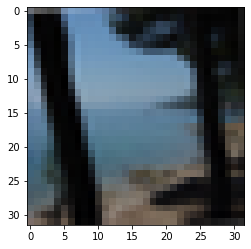

In [42]:
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import numpy as np

train_loader = torch.utils.data.DataLoader(
        dataset=datasets.CIFAR100(
        root='./data',
        train=True,
        transform=transforms.ToTensor(),
        download=True,
    ),
    batch_size=128,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
        dataset=datasets.CIFAR100(
        root='./data',
        train=False,
        transform=transforms.ToTensor(),
        download=True,
    ),
    batch_size=128,
    shuffle=False,
)

model = resnet101().to(device)

# show a example data
index = 10

dataiter = iter(test_loader)
(img, label) = next(dataiter)

print(img[0].shape)
print(class_names[label[index].item()])
plt.imshow(torch.rot90(img[index].T, 3))

## define hyperparameter

In [45]:
PATH = './model'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

remember to reset learning rate  

##### loss: 
3.4 -> 1.7 ->

##### lr:
0.01 -> 0.003

In [46]:
learning_rate = 0.003
num_epoch = 5
momentum = 0.9

loss_function = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=5e-4)

for epoch in range(num_epoch):
  for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()
    outputs = model(images)

    loss = loss_function(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:    
      print('epoch of mini-batch: ', i, ', loss: ', loss.item())

epoch of mini-batch:  0 , loss:  1.7193660736083984
epoch of mini-batch:  100 , loss:  1.2507575750350952
epoch of mini-batch:  200 , loss:  1.1393884420394897
epoch of mini-batch:  300 , loss:  1.2014245986938477
epoch of mini-batch:  0 , loss:  0.8105033040046692
epoch of mini-batch:  100 , loss:  0.7919186949729919
epoch of mini-batch:  200 , loss:  0.9615427255630493
epoch of mini-batch:  300 , loss:  0.9199841618537903
epoch of mini-batch:  0 , loss:  0.5366057753562927
epoch of mini-batch:  100 , loss:  0.5444014072418213
epoch of mini-batch:  200 , loss:  0.5994623303413391
epoch of mini-batch:  300 , loss:  0.5255579352378845
epoch of mini-batch:  0 , loss:  0.34390830993652344
epoch of mini-batch:  100 , loss:  0.3717098832130432
epoch of mini-batch:  200 , loss:  0.22656801342964172
epoch of mini-batch:  300 , loss:  0.2889983355998993
epoch of mini-batch:  0 , loss:  0.215179905295372
epoch of mini-batch:  100 , loss:  0.1777551919221878
epoch of mini-batch:  200 , loss:  0.

In [47]:
torch.save(model.state_dict(), PATH)

## test

### overall

In [48]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0

  for images, labels in test_loader:
    images = images.cuda()
    labels = labels.cuda()
    outputs = model(images)

    _, predictions = torch.max(outputs, 1)
    n_samples += labels.shape[0]
    n_correct += (predictions == labels).sum().item()

acc = 100.0 * n_correct / n_samples
print('acc: ', acc)

acc:  46.15


### sample

label is:  girl
prediction is:  boy


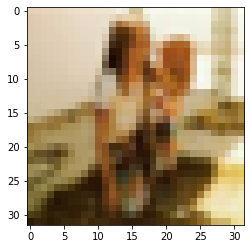

In [56]:
# test a example data
index = 99

dataiter = iter(test_loader)
(img, label) = next(dataiter)

plt.imshow(torch.rot90(img[index].T, 3))

with torch.no_grad():
  img = img.cuda()
  output = model(img)

  _, prediction = torch.max(output, 1)

  print('label is: ', class_names[label[index].item()])
  print('prediction is: ', class_names[prediction[index]])

## save